# Lab 8 Grover’s search with an unknown number of solutions

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import QFT, Diagonal, GroverOperator, MCMT
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

import numpy as np
import matplotlib.pyplot as plt

In [2]:
sim = AerSimulator()

## Part 1: Quantum Counting

### 1. Find the number of solutions of the given oracle for a search problem through quantum counting. 

#### Step A. Construct a gate for Grover iteration. 

In [3]:
# def initialize_s(qc, qubits):
#     """Apply a H-gate to 'qubits' in qc"""
#     for q in qubits:
#         qc.h(q)
#     return qc

In [4]:
def diffuser(myqc, m):
    for j in range(m):
        myqc.z(j)
        myqc.h(j)
    
    # apply multiply controlled-Z, which gives a phase to the all |1> state
    myqc.h(m-1)
    myqc.mcx(list(range(m-1)),m-1)
    myqc.h(m-1)
      
    # transform |1> to |+>
    for j in range(m):
        myqc.h(j)
        myqc.z(j)
        
    # get global phase of -1 (there must be a better way!)
    myqc.z(0)
    myqc.x(0)
    myqc.z(0)
    myqc.x(0)
    
    Diffuser = myqc.to_gate()
    return Diffuser

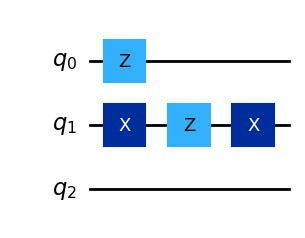

In [5]:
## Create an Oracle

N = 8 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

myqc = QuantumCircuit(m, name='Oracle')
myqc.x(1)
myqc.z(range(2))
myqc.x(1)
Oracle = myqc.to_gate()
myqc.draw(output='mpl')

In [6]:
hads = QuantumCircuit(m)
hads.h(range(m))
ket = Statevector(hads.compose(myqc))
ket.to_dict()

{'000': (-0.3535533905932737+0j),
 '001': (0.3535533905932737+0j),
 '010': (0.3535533905932737+0j),
 '011': (-0.3535533905932737+0j),
 '100': (-0.3535533905932737+0j),
 '101': (0.3535533905932737+0j),
 '110': (0.3535533905932737+0j),
 '111': (-0.3535533905932737+0j)}

&#128211; Complete the circuit, `qc`, to create Grover iteration gate/operator, `Grover`, by adding the diffuser, explained as the step 3 in the first section `1.Introdcution` of [Ch.3.10 Grover's Algorithm](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb).

In [7]:
qc = QuantumCircuit(m)
qc.append(Oracle, range(m))

### solution here
myqc = QuantumCircuit(m, name='Diffuser')

# transform |+> to |1>
Diffuser = diffuser(myqc, m)
qc.append(Diffuser, range(m))
####

Grover = qc.to_gate()

#### &#128211;Step B. Build a quantum circuit, <code>circ</code>, for quantum counting employing the IPE algorithm to find the eigenvalue of the Grover iterator, <code>Grover</code> that we made in Step A. 

In [8]:
###### solution here

# and a contolled version of the Grover iterator
def cGrover(k, Grover, m):
    
    # make gate for 2^k repetitions of grover
    qc = QuantumCircuit(m)
    for _ in range(2**k):
        qc.append(Grover, range(m))
    grover_k = qc.to_gate()
    grover_k.name = 'Grover_[2^'+str(k)+']'
    
    # make and return controlled version of this gate
    cGrover_k = grover_k.control()
    return cGrover_k 

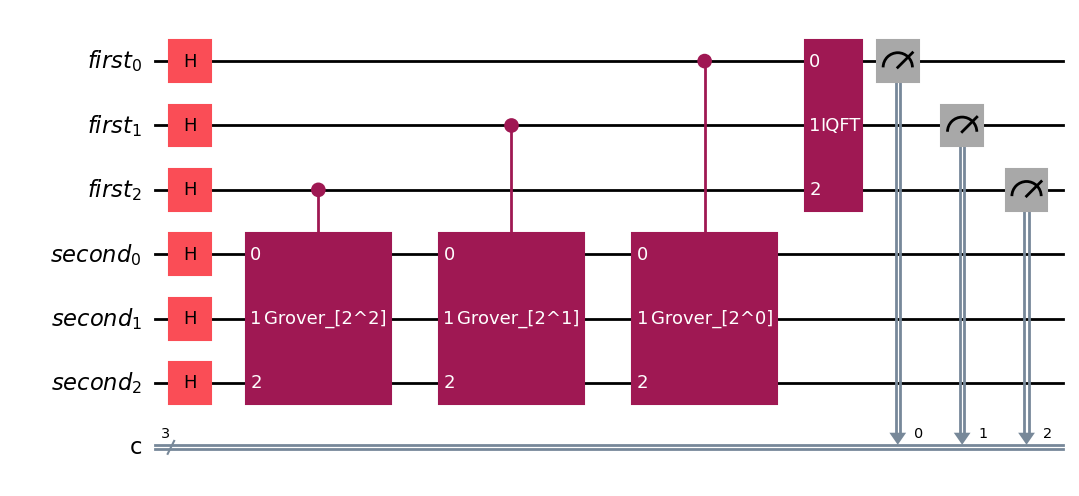

In [9]:
# number of bits required for the answer
t = 3

# we'll need the inverse QFT
qft = QFT(t)
inv_qft = qft.inverse()

# the first and second quantum registers, as in the lecture
first = QuantumRegister(t,'first')
second = QuantumRegister(m,'second')

# output for the second register
output = ClassicalRegister(t, name="c")

# now make the circuit
circ = QuantumCircuit(first, second, output)

# the first register is initialized as the all |+> state
circ.h(first)

# we'll prepare the |s> state for the qubits of the second register
circ.h(second)

# apply the controlled Grover ops
for k in range(t):    
    circ.append(cGrover(t-k-1, Grover, m), [first[t-k-1]]+[q for q in second] )
            
# do an inverse qft
circ.append(inv_qft, first)
        
# measure
circ.measure(first, output)
    

###################    
circ.draw('mpl')

#### &#128211;Step C. Execute the circuit that you built in Step B and find the number of solutions, $M$, from the estimated phase. 

In [10]:
def key_convert(count):
    phi_est = np.array([round(int(key, 2)/2**t, t) for key in list(count.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count.values()))
    return count_new

Results with bit strings {'110': 10048, '010': 9952}

Results with phases {'0.75': 10048, '0.25': 9952}


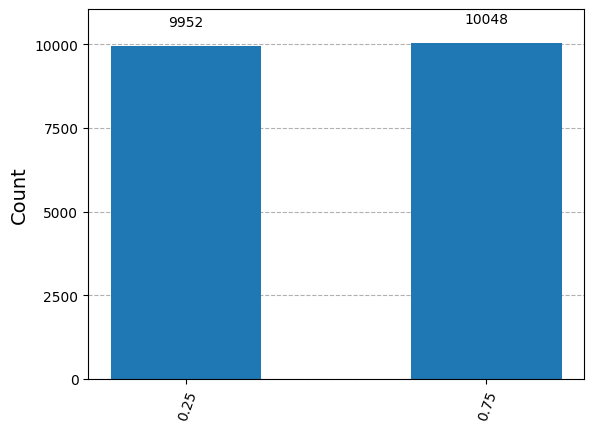

In [11]:
shots = 20000
####### solution here
compiled_circ = transpile(circ, sim)
count_circ = sim.run(compiled_circ, shots=shots).result().get_counts()
print('Results with bit strings',count_circ)

count_new = key_convert(count_circ)
print('\nResults with phases',count_new)

plot_histogram(count_new)

In [12]:
def get_solutions(count_new, N):
    errors = 0
    
    for phi in count_new:
        
        theta = float(phi)*np.pi
        
        if count_new[phi]>shots/10: # ignore spurious solutions
    
            M = np.rint(N * np.sin(theta)**2)
        
            print('Phase',phi,'implies',M,'solutions for the given oracle.')
            
        else:
            errors += count_new[phi]
            
    print('\nSpurious solutions occurred for',errors,'out of',shots,'shots.')
    return M

_ = get_solutions(count_new, N)

Phase 0.75 implies 4.0 solutions for the given oracle.
Phase 0.25 implies 4.0 solutions for the given oracle.

Spurious solutions occurred for 0 out of 20000 shots.


## Part 2: Implementing Grover's algorithem with an augmented Oracle

#### &#128211;Step A. Verify that the angle $\theta$ gets smaller as $M$ varies from $N/2$ to $N$. 

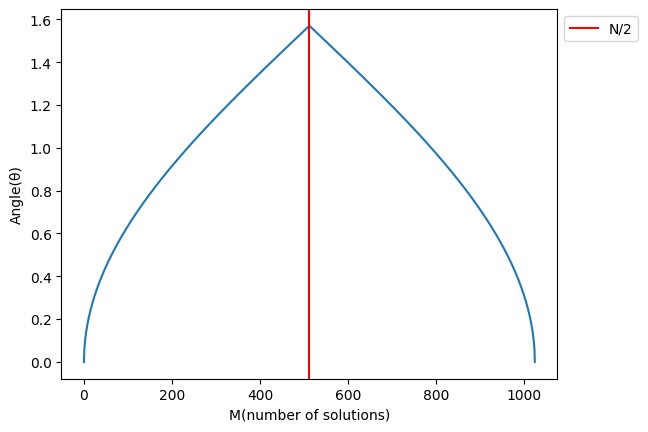

In [13]:
## Your code goes here
def get_plot(N):
    M = np.linspace(0, N, num=N)
    plt.plot(M, np.arcsin((2*np.sqrt(M*(N-M)))/N))
    plt.ylabel("Angle(θ)")
    plt.xlabel("M(number of solutions)")
    plt.axvline(x = N/2, color = 'r', label ='N/2')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    return plt.show()
get_plot(2**10)

#### &#128211;Step B. Obtain the angle $\theta$ and the number of the Grover iterations, $R$, needed to find the solutions of the oracle in Part 1 and interprete the result.

In [14]:
class Find_grover_params():
    '''
        M : number of solutions
        N : the search space
    '''
    def __init__(self, M, N):
        self.M = M
        self.N = N
    def theta(self):
        angle = np.arcsin((2*np.sqrt(self.M*(self.N-self.M)))/self.N)
        return angle
    def CI_R(self, theta):
        R = np.arccos(np.sqrt(self.M/self.N))/theta
        return np.rint(R)

In [15]:
# N = 8
# M = 4
# values taken directly from PART 1
## Your code goes here

find_params = Find_grover_params(4,8)
theta = find_params.theta()
print("Theta (θ): ",theta)
print("Number of the Grover iterations (R): ", find_params.CI_R(theta)) 

Theta (θ):  1.5707963267948966
Number of the Grover iterations (R):  0.0


Since M = 4 and N = 8 which means M>=N/2 hence no need to iterate grover to get solution.

###  2. Find the solutions to the search problem from Part 1. 

#### &#128211;Step A. Build a new augmented oracle gate/operator, <code>Oracle_new</code>, in the doubled search space.

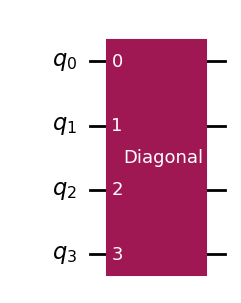

In [68]:
## your code goes here

N = 8 # same as part 1
m_ = int(np.log2(N)+1) # number of qubits
myqc_ = QuantumCircuit(m_, name='Oracle_new')
# double the search space
new_no_solution_states=[1]*N
oracle = Diagonal([-1,1,1,-1,-1,1,1,-1]+new_no_solution_states)
oracle_ = oracle.to_gate()
myqc_.append(oracle_, range(m_))
Oracle_new = myqc_.to_gate()
myqc_.draw(output='mpl')

In [69]:
hads_ = QuantumCircuit(m_)
hads_.h(range(m_))
ket_ = Statevector(hads_.compose(myqc_))
ket_.to_dict()

{'0000': (-0.25+0j),
 '0001': (0.25+0j),
 '0010': (0.25+0j),
 '0011': (-0.25+0j),
 '0100': (-0.25+0j),
 '0101': (0.25+0j),
 '0110': (0.25+0j),
 '0111': (-0.25+0j),
 '1000': (0.25+0j),
 '1001': (0.25+0j),
 '1010': (0.25+0j),
 '1011': (0.25+0j),
 '1100': (0.25+0j),
 '1101': (0.25+0j),
 '1110': (0.25+0j),
 '1111': (0.25+0j)}

#### &#128211;Step B. Evaluate the number of Grover iterations, $R$, needed to find $M$ solutions among the total 16 items.

In [70]:
find_params_new = Find_grover_params(M=4, N=16)
theta_new = find_params_new.theta()
print("Theta (θ): ",theta_new)
print("Number of the Grover iterations (R): ", find_params_new.CI_R(theta_new)) 

Theta (θ):  1.0471975511965976
Number of the Grover iterations (R):  1.0


#### &#128211;Step C. Create a quantum circuit <code>qc_final</code> to find solutions to the search problem applying Grover iteration <code>R</code> times.

In [71]:
## Your code goes here
qc_ = QuantumCircuit(m_)
qc_.append(Oracle_new, range(m_))

Diffuser_ = diffuser(QuantumCircuit(m_, name='Diffuser'), m_)
qc_.append(Diffuser_, range(m_))

Grover_ = qc_.to_gate()

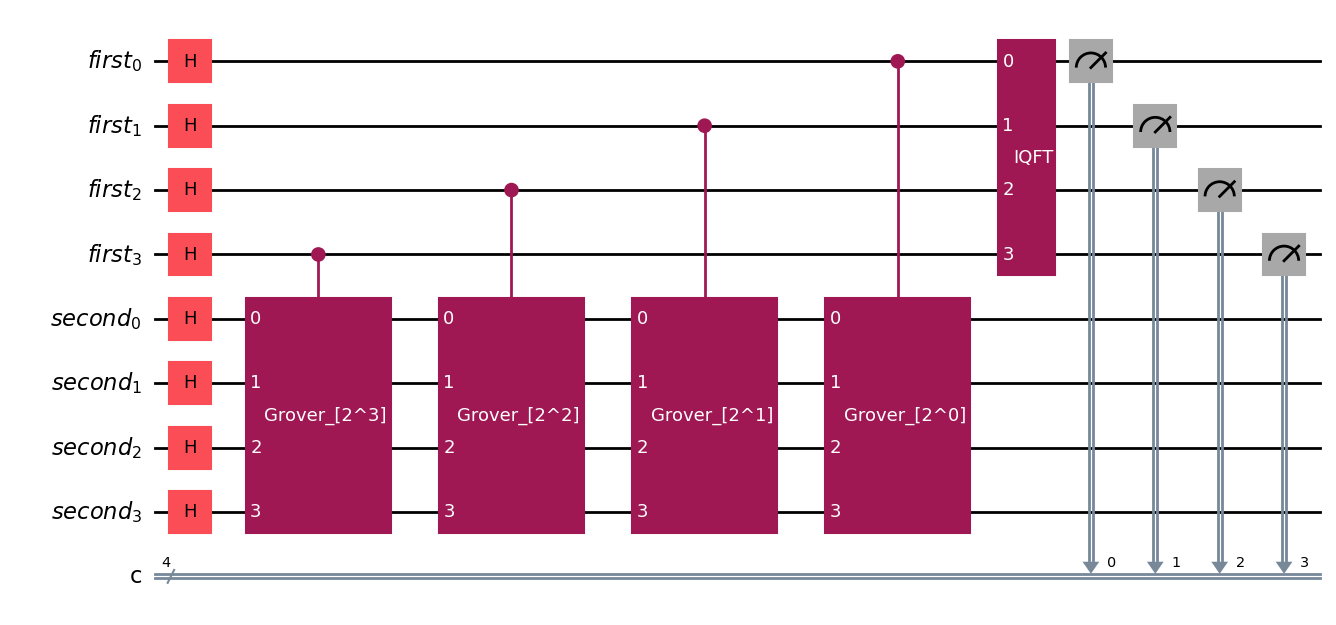

In [72]:
##########################  

# number of bits required for the answer
t_ = 4

# we'll need the inverse QFT
qft_ = QFT(t_)
inv_qft_ = qft_.inverse()


# the first and second quantum registers, as in the lecture
first_ = QuantumRegister(t_,'first')
second_ = QuantumRegister(m_,'second')

# output for the second register
output_ = ClassicalRegister(t_, name="c")

# now make the circuit
qc_final = QuantumCircuit(first_, second_, output_)

# the first register is initialized as the all |+> state
qc_final.h(first_)

# we'll prepare the |s> state for the qubits of the second register
qc_final.h(second_)

# apply the controlled Grover ops
for k in range(t_):    
    qc_final.append(cGrover(t_-k-1, Grover_, m_), [first_[t_-k-1]]+[q for q in second_] )
            
# do an inverse qft
qc_final.append(inv_qft_, first_)
        
# measure
qc_final.measure(first_, output_)
qc_final.draw("mpl")

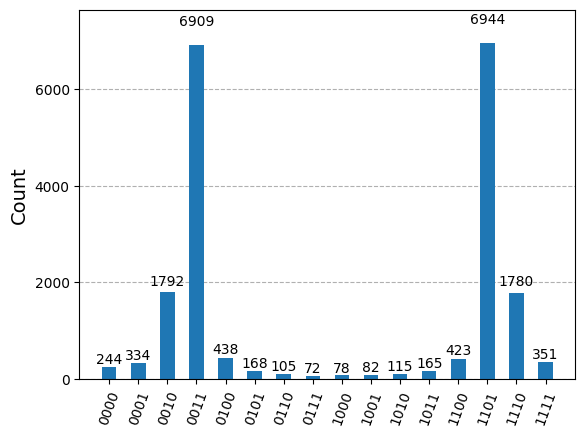

In [73]:
# aer_sim = Aer.get_backend('aer_simulator')
counts_ = sim.run(transpile(qc_final, sim), shots=20000).result().get_counts()
plot_histogram(counts_)

In [74]:
print('Results with bit strings',counts_)

Results with bit strings {'1011': 165, '0010': 1792, '0100': 438, '1101': 6944, '0001': 334, '1110': 1780, '1100': 423, '0011': 6909, '1111': 351, '0101': 168, '0110': 105, '1010': 115, '0111': 72, '1001': 82, '0000': 244, '1000': 78}


In [75]:
countp_ = key_convert(counts_)
print('\nResults with phases',countp_)


Results with phases {'1.375': 165, '0.25': 1792, '0.5': 438, '1.625': 6944, '0.125': 334, '1.75': 1780, '1.5': 423, '0.375': 6909, '1.875': 351, '0.625': 168, '0.75': 105, '1.25': 115, '0.875': 72, '1.125': 82, '0.0': 244, '1.0': 78}


In [76]:
get_solutions(countp_, 2*N) # N is 16

Phase 1.625 implies 14.0 solutions for the given oracle.
Phase 0.375 implies 14.0 solutions for the given oracle.

Spurious solutions occurred for 6147 out of 20000 shots.


14.0

#### &#128211;Step D. Check if the solutions are correct using the original oracle, <code>Oracle</code>, in Part 1.

When using the new oracle we get 6319 spurious hits out of 20000 shots during the cicuit run, this potenially results in 14 solutions whereaas using the old oracle we only received 4 solution which is what was expected since there are no spurious hits

## Part 3: Grover circuit on Noisy Quantum System

#### Step A. Run the following cell to load your account and set the backend. 

In [54]:
from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeKyiv, FakeKyoto

In [55]:
backend = FakeKyoto()

#### &#128211;Step B. Generate multiple ( as many as you want ) transpiled circuits of <code>qc_final</code>. Choose one with the minimum circuit depth.

In [56]:
num = 2
qc_trans = transpile([qc_final]*num, backend, optimization_level=3)
qc_trans_depth = np.array([qc_trans[idx].depth() for idx in range(num)])

#####################
print("OK ✅")

OK ✅


#### &#128211;Step C. Execute the circuit on the backend. 

In [57]:
shots=20000
noise_model = NoiseModel.from_backend(backend)
counts_noise = sim.run(qc_trans, noise_model=noise_model, shots=shots).result().get_counts()

#### &#128211;Step D. Plot the histogram of the result from <code>ibmq_athens</code> together with the simulation result to compare and discuss how noise affects the result.

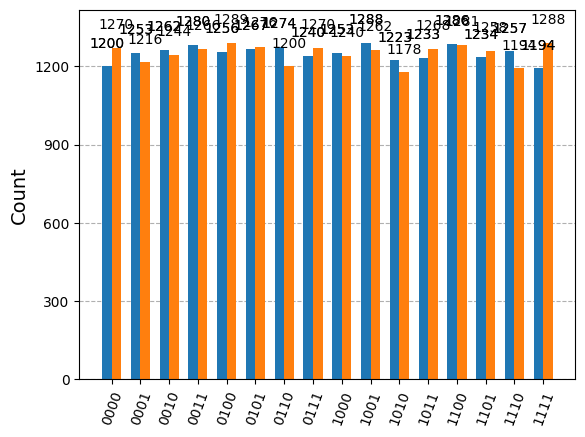

In [58]:
plot_histogram(counts_noise)

We observe that in the presence of noise we get more spurious hits than without noise and that each measured phase points almost equally to a solution.